# 첫 번째 신경망 훈련하기: 기초적인 분류 문제


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2024-06-24 08:42:18.084291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


2.4.0


## 패션 MNIST 데이터셋 임포트하기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 패션 MNIST 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

Fashion MNIST sprite
그림 1. 패션-MNIST 샘플 (Zalando, MIT License).

<img src = "https://tensorflow.org/images/fashion-mnist-sprite.png">
 
패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 MNIST 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.

패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.

네트워크를 훈련하는데 60,000개의 이미지를 사용합니다. 그다음 네트워크가 얼마나 정확하게 이미지를 분류하는지 10,000개의 이미지로 평가하겠습니다. 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 적재할 수 있습니다:

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

train_images와 train_labels 배열은 모델 학습에 사용되는 훈련 세트입니다.
test_images와 test_labels 배열은 모델 테스트에 사용되는 테스트 세트입니다.
이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. 레이블(label)은 0에서 9까지의 정수 배열입니다. 
이 값은 이미지에 있는 옷의 클래스(class)를 나타냅니다:

|레이블|클래스|
|---|:---|
|0|T-shirt/top
|1|Trouser    
|2|Pullover   
|3|Dress      
|4|Coat       
|5|Sandal     
|6|Shirt      
|7|Sneaker    
|8|Bag        
|9|Ankle boot 

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 클래스 이름이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 
별도의 변수를 만들어 저장합니다:

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [4]:
train_images.shape

(60000, 28, 28)

비슷하게 훈련 세트에는 60,000개의 레이블이 있습니다

In [5]:
len(train_labels)

60000

각 레이블은 0과 9사이의 정수입니다:

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있습니다. 이 이미지도 28x28 픽셀로 표현됩니다:

In [7]:
test_images.shape

(10000, 28, 28)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있습니다:

In [8]:
len(test_labels)

10000

## 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수
있습니다:

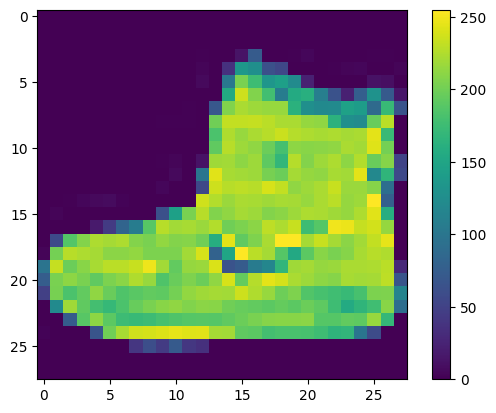

In [9]:
# matplotlib에서 .figure( )함수는 Figure객체를 생성해준다. Figure객체란 한 개 이상의 축(Axes)을 포함한 객체이다.
plt.figure()
# .imshow( )함수는 픽셀 데이터를 이미지로 출력해주는 함수이다. train_images 중 첫 번째 데이터를 이미지화 한다.
plt.imshow(train_images[0])
# colorbar는 특정 휘도값과 색도값을 나타내는 수직형 컬러 막대이다. train_images[0]의 픽셀을 colorbar값으로 표현한다.(0~255)
plt.colorbar()
plt.grid(False)   # grid는 그래프를 그릴 시 값 표시선이다. 
plt.show()   # .show( )는 생성된 모든 Figure 객체를 보여준다.

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. 훈련 세트와 테스트 세트를 동일한 방식으로 전처리하는 것이 중요합니다:

In [10]:
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


훈련 세트에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

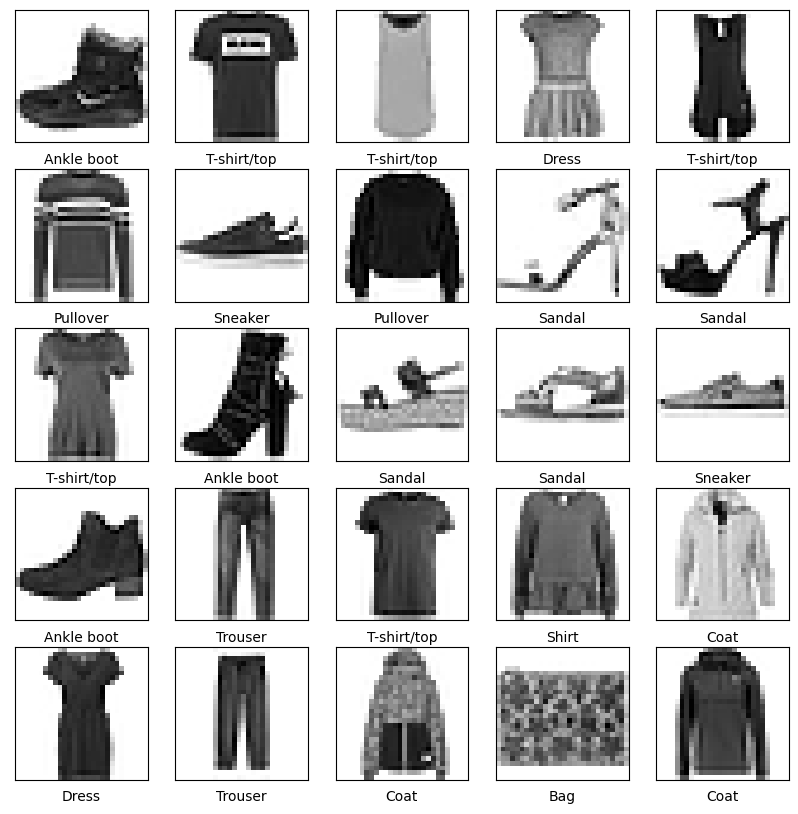

In [11]:
# 차트 그림(figure)의 기본 크기 지정
plt.figure(figsize=(10,10))

for i in range(25):   # 0~24, 총 25개의 이미지와 클래스 출력 반복문
    # subplot()함수는 한 화면에 여러 개의 figure 객체를 그리기위한 함수이다.
    plt.subplot(5,5,i+1)   # 5, 5 사이즈로 25개의 figure 객체 생성
    plt.xticks([])   # x축의 틱을 표현, plt.xticks([])이므로 표현하지 않음
    plt.yticks([])   # y축의 틱을 표현, plt.xticks([])이므로 표현하지 않음
    plt.grid(False)   # figure의 grid를 보여주지 않는다.
    plt.imshow(train_images[i], cmap=plt.cm.binary)   # i에 해당하는 픽셀 데이터를 흑백 칼라맵 이미지로 출력
    plt.xlabel(class_names[train_labels[i]])   # i에 해당하는 클래스명을 x축 라벨로 출력

plt.show()   # 생성된 모든 figure 객체 반환

## 모델 구성

신경망 모델을 만들려면 모델의 층을 구성한 다음 모델을 컴파일합니다.

### 층 설정
신경망의 기본 구성 요소는 층(layer)입니다. 층은 주입된 데이터에서 표현을 추출합니다. 아마도 문제를 해결하는데 더 의미있는 표현이 추출될 것입니다.

대부분 딥러닝은 간단한 층을 연결하여 구성됩니다. tf.keras.layers.Dense와 같은 층들의 가중치(parameter)는 훈련하는 동안 학습됩니다.

In [12]:
#model = keras.Sequential([   # Sequential 모델은 레이어를 선형으로 연결하여 구성.
#    keras.layers.Flatten(input_shape=(28, 28)),   # 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환
#    keras.layers.Dense(128, activation='relu'),   # 덴스(dense)레이어는 이전 레이어의 모든 뉴런과 결합된 형태의 레이어이다.
#    keras.layers.Dense(10, activation='softmax')   # 소프트맥스 함수는 다중 클래스분류 문제에서 출력층에 주로 사용됨
#])

model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

2024-06-24 08:43:09.056688: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-24 08:43:09.058902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-24 08:43:09.154566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:8a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-06-24 08:43:09.154613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-06-24 08:43:09.158451: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-06-24 08:43:09.158543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________


이 네트워크의 첫 번째 층인 tf.keras.layers.Flatten은 2차원 배열(28 x 28 픽셀)의 이미지 포맷을 28 * 28 = 784 픽셀의 1차원 배열로 변환합니다. 이 층은 이미지에 있는 픽셀의 행을 펼쳐서 일렬로 늘립니다. 이 층에는 학습되는 가중치가 없고 데이터를 변환하기만 합니다.

픽셀을 펼친 후에는 두 개의 tf.keras.layers.Dense 층이 연속되어 연결됩니다. 이 층을 밀집 연결(densely-connected) 또는 완전 연결(fully-connected) 층이라고 부릅니다. 첫 번째 Dense 층은 128개의 노드(또는 뉴런)를 가집니다. 두 번째 (마지막) 층은 10개의 노드의 소프트맥스(softmax) 층입니다. 이 층은 10개의 확률을 반환하고 반환된 값의 전체 합은 1입니다. 각 노드는 현재 이미지가 10개 클래스 중 하나에 속할 확률을 출력합니다.

### 모델 컴파일

모델을 훈련하기 전에 필요한 몇 가지 설정이 모델 컴파일 단계에서 추가됩니다:

**손실 함수(Loss function)** 훈련 하는 동안 모델의 오차를 측정합니다. 모델의 학습이 올바른 방향으로 향하도록 이 함수를 최소화해야 합니다.

**옵티마이저(Optimizer)** 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정합니다.

**지표(Metrics)** 훈련 단계와 테스트 단계를 모니터링하기 위해 사용합니다. 다음 예에서는 올바르게 분류된 이미지의 비율인 정확도를 사용합니다.

In [13]:
model.compile(optimizer='adam',   # 최적화 옵티마이저로 Adam 사용
              # 라벨이 정수 형태(ex.0, 1, 2 ...)로 제공되며,분류해야할 클래스가 3개 이상인 경우의 멀티 클래스 분류를 위한 손실함수이다.
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])   # 정확도(accuracy)를 모니터링을 위한 지표로 사용

## 모델 훈련

신경망 모델을 훈련하는 단계는 다음과 같습니다:

1. 훈련 데이터를 모델에 주입합니다-이 예에서는 train_images와 train_labels 배열입니다.
2. 모델이 이미지와 레이블을 매핑하는 방법을 배웁니다.
3. 테스트 세트에 대한 모델의 예측을 만듭니다-이 예에서는 test_images 배열입니다. 이 예측이 test_labels 배열의 레이블과 맞는지 확인합니다.

훈련을 시작하기 위해 model.fit 메서드를 호출하면 모델이 훈련 데이터를 학습합니다:

In [14]:
# model.fit(훈련 데이터셋, 훈련 라벨, 전체 데이터 5번 사용해서 학습)
tf_history = model.fit(train_images, train_labels, epochs=5)


2024-06-24 08:43:19.882598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-24 08:43:19.904557: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2195115000 Hz


Epoch 1/5


2024-06-24 08:43:20.183472: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-06-24 08:43:20.584194: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-06-24 08:43:20.586447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1875/1875 [==============================] - 8s 3ms/step - loss: 0.7425 - accuracy: 0.7557
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4005 - accuracy: 0.8598
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3573 - accuracy: 0.8747
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3380 - accuracy: 0.8805
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3176 - accuracy: 0.8862


모델이 훈련되면서 손실과 정확도 지표가 출력됩니다. 이 모델은 훈련 세트에서 약 0.88(88%) 정도의 정확도를 달성합니다.

### 정확도 평가

그다음 테스트 세트에서 모델의 성능을 비교합니다:


In [15]:
# model.evaluate() 함수는 모델 평가에 사용되는 함수이다.
# verbose는 학습 중 출력되는 문구를 설정한다.
# verbose = 0 : 아무 것도 출력하지 않는다.
# verbose = 1 : 훈련의 진행도를 보여주는 진행 막대(progress bar)를 보여준다.
# verbose = 2 : 미니 배치마다 손실 정보를 출력한다.
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2) 

print('\n테스트 정확도:', test_acc)

313/313 - 1s - loss: 0.3560 - accuracy: 0.8735

테스트 정확도: 0.8734999895095825


테스트 세트의 정확도가 훈련 세트의 정확도보다 조금 낮습니다. 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문입니다. 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상을 말합니다.

### 예측 만들기

훈련된 모델을 사용하여 이미지에 대한 예측을 만들 수 있습니다.

In [16]:
# model.predict(input)는 input에 대한 결과값 예측을 생성한다.
predictions = model.predict(test_images)

여기서는 테스트 세트에 있는 각 이미지의 레이블을 예측했습니다. 첫 번째 예측을 확인해 보죠:

In [17]:
# predictions에는 해당 데이터의 모든 레이블값의 확률을 출력한다.
predictions[0]

array([3.3129108e-06, 1.9960078e-07, 3.2217804e-06, 7.4722232e-07,
       1.1416643e-06, 7.4219913e-03, 2.4576499e-05, 1.1674904e-01,
       2.0350360e-03, 8.7376070e-01], dtype=float32)

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [18]:
# argmax는 다차원 배열의 경우 차원에 따라 가장 큰 값의 인덱스를 반환해준다.
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(class_name[9])라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [19]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현해 보겠습니다:

In [20]:
# i번째 이미지 데이터에 대해 예측값 배열을 얻어와 예측값을 도출하고, 정답 레이블과 비교하여 이미지로 출력하는 함수
def plot_image(i, predictions_array, true_label, img):   
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)   # 그리드는 표시하지 않음
  plt.xticks([])   # x축 틱은 표시하지 않음
  plt.yticks([])   # y축 틱은 표시하지 않음

  plt.imshow(img, cmap=plt.cm.binary)   # img의 픽셀 데이터를 흑백 칼라맵 이미지로 출력

  predicted_label = np.argmax(predictions_array)   # 10가지 예측값 중 가장 정확도가 높은 값을 뽑음
  if predicted_label == true_label:   # 만약 모델의 예측값과 정답 레이블이 같다면 파랑
    color = 'blue'
  else:   # 만약 모델의 예측값과 정답 레이블이 다르다면 빨강
    color = 'red'

  # "{} {:2.0f}% ({})" 에서 왼쪽부터 class_names[predicted_label], 
  # {:2.0f}%에는 100*np.max(predictions_array) %, ({})에는 class_names[true_label])이 들어간다.
  # color는 위에서처럼 예측이 맞으면 파랑, 틀리면 빨강으로 설정된다.
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


# i번째 이미지 데이터에 대해 예측값 배열을 얻어와 예측값을 도출하고, 정답 레이블과 비교하여 그래프로 출력하는 함수
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")   # 10가지의 예측값에 대해 막대그래프로 표현, #777777은 회색이다.
  plt.ylim([0, 1])   # 그림의 범위 중, y축의 최소값과 최대값을 수동으로 지정한다.
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')   # 예측값에 대한 색은 파랑으로 설정
  thisplot[true_label].set_color('blue')   # 정답 레이블에 대한 색은 빨강으로 설정

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

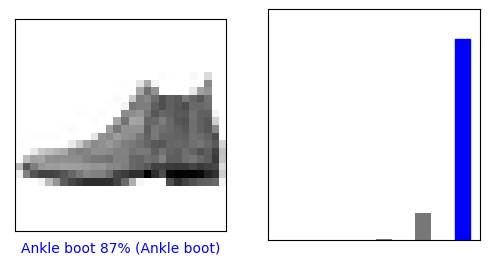

In [21]:
# test 데이터셋에서 첫 번째 데이터에 대한 figure 생성
i = 0
plt.figure(figsize=(6,3))

# subplot()함수는 한 화면에 여러 개의 figure 객체를 그리기위한 함수이다.
plt.subplot(1,2,1)   # plt.subplot(행의 수, 열의 수, 순서)이다.
plot_image(i, predictions, test_labels, test_images)

plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

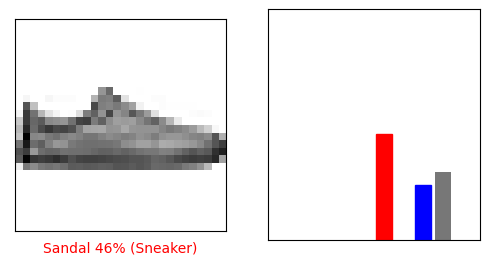

In [22]:
# test 데이터셋에서 열세 번째 데이터에 대한 figure 생성
i = 12
plt.figure(figsize=(6,3))

# subplot()함수는 한 화면에 여러 개의 figure 객체를 그리기위한 함수이다.
plt.subplot(1,2,1)   # plt.subplot(행의 수, 열의 수, 순서)이다.
plot_image(i, predictions, test_labels, test_images)

plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

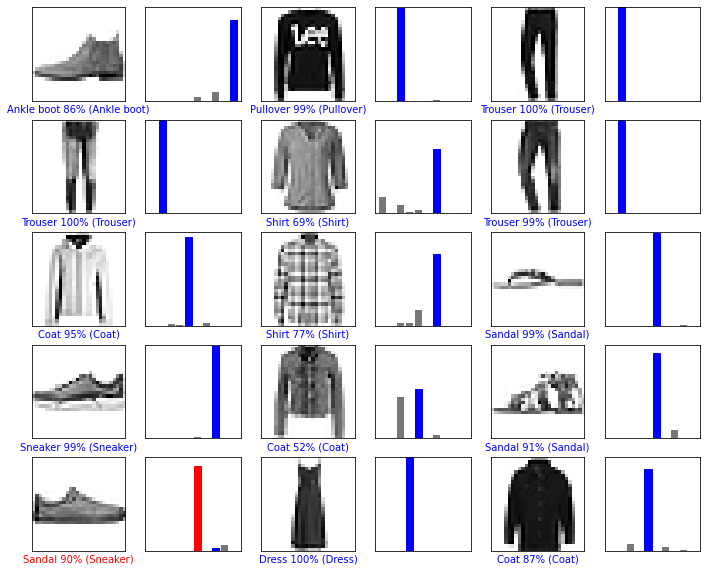

In [23]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력한다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타낸다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))   # figsize는 (12, 10)

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

plt.show()

# Cheetah model로 업로드

이제 훈련된 텐서플로우 모델을 Cheetah의 모델로 등록합니다. 모델 등록 시에는 Cheetah에서 제공되는 Python 라이브러리를 사용합니다.

In [26]:
model.save('fashionmnist_model.h5')
